### Plate Velocities

This notebook goes through steps to generate plate velocities (assuming that you have a topological plate model)

In [1]:
import sys
sys.path.insert(1, '/Users/Andrew/Documents/PhD/Scripts/Python/pygplates_rev12')
import pygplates
import numpy as np

def make_GPML_velocity_feature(Long,Lat):
# function to make a velocity mesh nodes at an arbitrary set of points defined in Lat
# Long and Lat are assumed to be 1d arrays. 
# Filename should have extension .gpml or .gpmlz

    # Add points to a multipoint geometry
    SeedPoints = zip(Lat,Long)
    points = []
    for j in range(0,len(SeedPoints)):
        points.append(SeedPoints[j])
    multi_point = pygplates.MultiPointOnSphere(points)

    # Create a feature containing the multipoint feature, and defined as MeshNode type
    meshnode_feature = pygplates.Feature(pygplates.FeatureType.create_from_qualified_string('gpml:MeshNode'))
    meshnode_feature.set_geometry(multi_point)
    meshnode_feature.set_name('Velocity Mesh Nodes from pygplates')

    output_feature_collection = pygplates.FeatureCollection(meshnode_feature)
    
    # NB: at this point, the feature could be written to a file using
    # output_feature_collection.write('filename.gpml')
    
    return output_feature_collection

    
    
#######
# Run test case
# Generate points for regular long,lat grid
Xnodes = np.arange(-180,180,2)
Ynodes = np.arange(-90,90,2)
Xg,Yg = np.meshgrid(Xnodes,Ynodes)
Xg = Xg.flatten()
Yg = Yg.flatten()

velocity_domain_features = make_GPML_velocity_feature(Xg,Yg)



In [2]:
reconstruction_time = 700
delta_time = 1

all_reconstructed_points = []
all_velocities = []
xy_reconstructed_points = []

domain_features = pygplates.FeatureCollection(
    '/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Kinematic_tests/Aus_Laurentia_kinematics.gpml')

input_rotation_filename = '/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Kinematic_tests/Aus-Laurentia-SWEAT.rot'
rotation_model = pygplates.RotationModel(input_rotation_filename)

In [3]:
for feature in domain_features:
    
    # We need the feature's plate ID to get the equivalent stage rotation of that tectonic plate.
    domain_plate_id = feature.get_reconstruction_plate_id()

    # Get the rotation of plate 'domain_plate_id' from present day (0Ma) to 'reconstruction_time'.
    equivalent_total_rotation = rotation_model.get_rotation(reconstruction_time, domain_plate_id)

    # Get the rotation of plate 'domain_plate_id' from 'reconstruction_time + delta_time' to 'reconstruction_time'.
    equivalent_stage_rotation = rotation_model.get_rotation(reconstruction_time, domain_plate_id, reconstruction_time + delta_time)
    
    for geometry in feature.get_geometries():

        # Reconstruct the geometry to 'reconstruction_time'.
        reconstructed_geometry = equivalent_total_rotation * geometry
        reconstructed_points = reconstructed_geometry.get_points()
        xy_reconstructed_points = reconstructed_points.to_lat_lon_array()
                     
        all_reconstructed_points.append(xy_reconstructed_points)

In [4]:
poly_longs = []
poly_lats = []
for i in all_reconstructed_points:
    j = i[:,0]
    k = i[:,1]
    poly_longs.append(k)
    poly_lats.append(j)

/Users/Andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


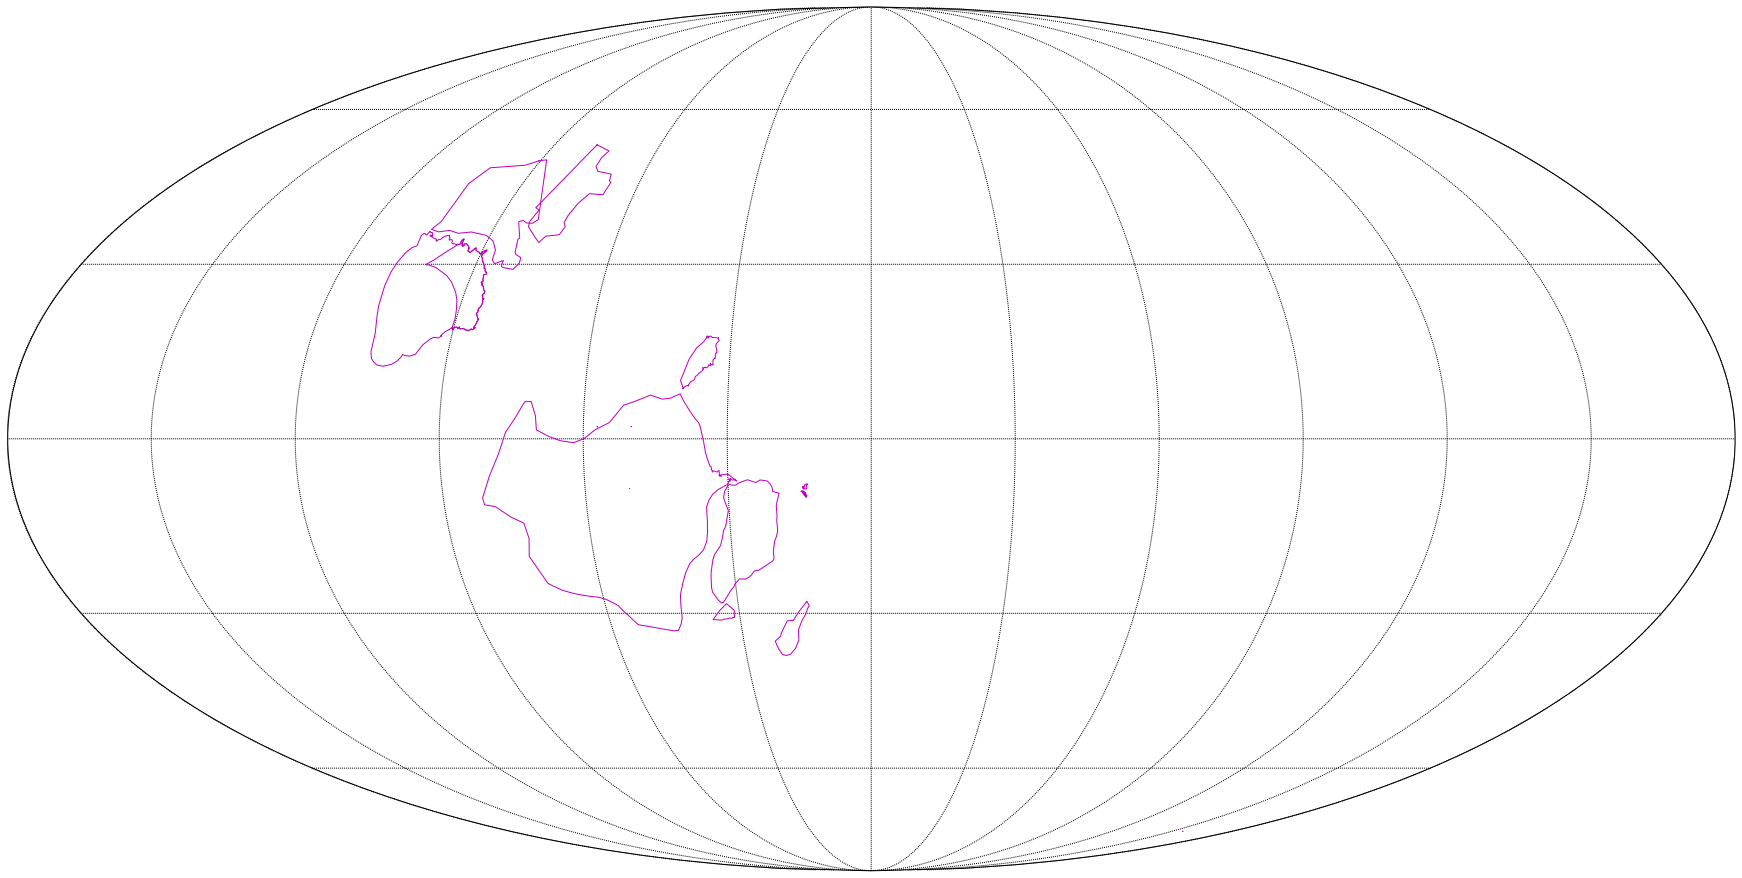

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline

# Make the figure and a dummy orthographic map to get extents
fig = plt.figure(figsize=(48,24),dpi=300)
lat_0=0. ; lon_0=180.
m = Basemap(projection='moll',lon_0=lon_0,lat_0=lat_0,resolution=None)
ax = fig.add_axes([0.0,0.1,0.5,0.8],axisbg='k')
m = Basemap(projection='moll',lon_0=lon_0,lat_0=lat_0,resolution='l')
          
clip_path = m.drawmapboundary(fill_color='white')
m.drawmeridians(np.arange(0, 360, 30))
m.drawparallels(np.arange(-90, 90, 30))
ax = plt.gca()

for latitudes, longitudes in zip(poly_lats,poly_longs):
    x_geom,y_geom = m(longitudes, latitudes)
    m.plot(x_geom,y_geom,color='m')

plt.show()

In [6]:
import pygplates

rotation_filename = '/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Kinematic_tests/Aus-Laurentia-SWEAT.rot'

input_topology_filename = '/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Kinematic_tests/Aus_Laurentia_kinematics.gpml'


# Load one or more rotation files into a rotation model.
rotation_model = pygplates.RotationModel(rotation_filename)

# Load the topological plate polygon features.
topology_features = pygplates.FeatureCollection(input_topology_filename)


# Calculate velocities using a delta time interval of XMy.
delta_time = 10

#select interval of time
to_time = 700
from_time = 700

In [7]:
import pygplates

rotation_filename = '/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Kinematic_tests/Aus-Laurentia-SWEAT.rot'

input_topology_filename = '/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Kinematic_tests/Aus_Laurentia_kinematics.gpml'


# Load one or more rotation files into a rotation model.
rotation_model = pygplates.RotationModel(rotation_filename)

# Load the topological plate polygon features.
topology_features = pygplates.FeatureCollection(input_topology_filename)


# Calculate velocities using a delta time interval of XMy.
delta_time = 10

#select interval of time
to_time = 700
from_time = 700

# 'time' = 0, 1, 2, ... , 140
for time in range(to_time, from_time + 1, delta_time):

    print 'Time: %d' % time

    # All domain points and associated (magnitude, azimuth, inclination) velocities for the current time.
    all_domain_points = []
    all_velocities = []

    # Partition our velocity domain features into our topological plate polygons at the current 'time'.
    plate_partitioner = pygplates.PlatePartitioner(topology_features, rotation_model, time)

    for velocity_domain_feature in velocity_domain_features:

        # A velocity domain feature usually has a single geometry but we'll assume it can be any number.
        # Iterate over them all.
        for velocity_domain_geometry in velocity_domain_feature.get_geometries():

            for velocity_domain_point in velocity_domain_geometry.get_points():

                all_domain_points.append(velocity_domain_point)

                partitioning_plate = plate_partitioner.partition_point(velocity_domain_point)
                if partitioning_plate:

                    # We need the newly assigned plate ID to get the equivalent stage rotation of that tectonic plate.
                    partitioning_plate_id = partitioning_plate.get_feature().get_reconstruction_plate_id()

                    # Get the stage rotation of partitioning plate from 'time + delta_time' to 'time'.
                    equivalent_stage_rotation = rotation_model.get_rotation(time, partitioning_plate_id, time + delta_time)

                    # Calculate velocity at the velocity domain point.
                    # This is from 'time + delta_time' to 'time' on the partitioning plate.
                    velocity_vectors = pygplates.calculate_velocities(
                        [velocity_domain_point],
                        equivalent_stage_rotation,
                        delta_time)

                    # Convert global 3D velocity vectors to local (magnitude, azimuth, inclination) tuples (one tuple per point).
                    velocities = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(
                            [velocity_domain_point],
                            velocity_vectors)
                    all_velocities.append(velocities[0])

                else:
                    all_velocities.append((0,0,0))
    
pt_vel_mag=[]
pt_vel_az=[]
for vel in all_velocities:
    pt_vel_mag.append(vel[0])
    pt_vel_az.append(vel[1])


pt_lon = []
pt_lat = []
for pt in all_domain_points:
    pt_lon.append(pt.to_lat_lon()[1])
    pt_lat.append(pt.to_lat_lon()[0])


Time: 700


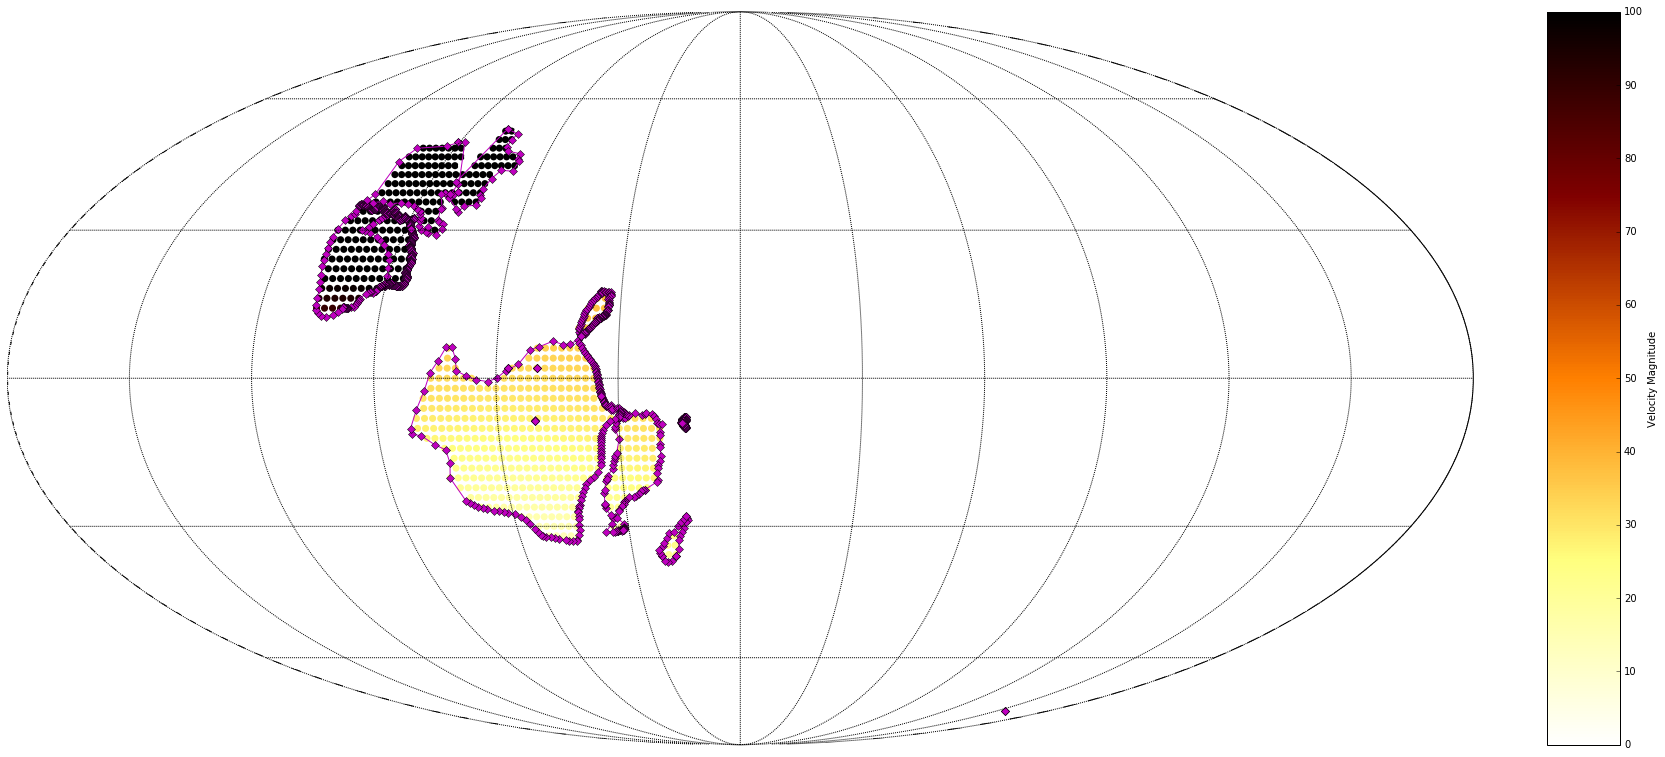

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid

%matplotlib inline

fig = plt.figure(figsize=(28,20),dpi=300)
ax_map = fig.add_axes([0,0,0.8,1.0])
#ax_cbr = fig.add_axes([0.91,0.3,0.01,0.4])
# set up map
m1 = Basemap(projection='moll', lon_0=180, resolution='c', ax=ax_map)
cp = m1.drawmapboundary()
for latitudes, longitudes in zip(poly_lats,poly_longs):
    x_geom,y_geom = m1(longitudes, latitudes)
    m1.plot(x_geom,y_geom,marker='D',color='m')
m1.drawparallels(np.arange(-90,90,30))
m1.drawmeridians(np.arange(-180,180,30))

x,y = m1(pt_lon,pt_lat)
im = m1.scatter(x,y,c=pt_vel_mag,edgecolor='',s=50,cmap=plt.cm.afmhot_r,vmin=0,vmax=100)

# add colorbar.
cbar = m1.colorbar(im,location='right',pad="5%")
cbar.set_label('Velocity Magnitude')

plt.show()

### Plotting velocity vectors using basemap

Basemap can plot velocity vectors, for which we need the north and east components of the velocity vector.

The code below shows how to access these values. Note the (potentially confusing) notation that GPlates uses for converting x and y directions to Long/Lat. 


In [8]:
import pygplates
import numpy as np

rotation_filename = '/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Kinematic_tests/Aus-Laurentia-SWEAT.rot'

input_topology_filename = '/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Kinematic_tests/Aus_Laurentia_kinematics.gpml'

# Load one or more rotation files into a rotation model.
rotation_model = pygplates.RotationModel(rotation_filename)

# Load the topological plate polygon features.
topology_features = pygplates.FeatureCollection(input_topology_filename)

# Calculate velocities using a delta time interval of 1My.
delta_time = 1

# 'time' = 0, 1, 2, ... , 140
time = 700

# All domain points and associated (magnitude, azimuth, inclination) velocities for the current time.
all_domain_points = []
all_velocities = []

pt_vel_n=[]
pt_vel_e=[]

# Partition our velocity domain features into our topological plate polygons at the current 'time'.
plate_partitioner = pygplates.PlatePartitioner(topology_features, rotation_model, time)

for velocity_domain_feature in velocity_domain_features:

    # A velocity domain feature usually has a single geometry but we'll assume it can be any number.
    # Iterate over them all.
    for velocity_domain_geometry in velocity_domain_feature.get_geometries():

        for velocity_domain_point in velocity_domain_geometry.get_points():

            all_domain_points.append(velocity_domain_point)

            partitioning_plate = plate_partitioner.partition_point(velocity_domain_point)
            if partitioning_plate:

                # We need the newly assigned plate ID to get the equivalent stage rotation of that tectonic plate.
                partitioning_plate_id = partitioning_plate.get_feature().get_reconstruction_plate_id()

                # Get the stage rotation of partitioning plate from 'time + delta_time' to 'time'.
                equivalent_stage_rotation = rotation_model.get_rotation(time, partitioning_plate_id, time + delta_time)

                # Calculate velocity at the velocity domain point.
                # This is from 'time + delta_time' to 'time' on the partitioning plate.
                velocity_vectors = pygplates.calculate_velocities([velocity_domain_point], equivalent_stage_rotation, delta_time)
                
                # Convert global 3D velocity vectors to local (magnitude, azimuth, inclination) tuples (one tuple per point).
                velocities = pygplates.LocalCartesian.convert_from_geocentric_to_north_east_down(
                        [velocity_domain_point],
                        velocity_vectors)
                all_velocities.append(velocities[0])
 
                

#                pt_vel_e.append(velocity_domain_point.get_y())
#                pt_vel_n.append(velocity_domain_point.get_x())
                
            else:
                all_velocities.append((0,0,0))

# Note about units:
# The strain_sphere function expects metres / year
# pygplates defaults to velocities in km/Myr
# therefore, we here divide by 1000 to make plate velocities consistent with strain calc. 
pt_vel_n=[]
pt_vel_e=[]
for vel in all_velocities:
    if type(vel) == tuple:
        pt_vel_e.append(0)
        pt_vel_n.append(0)
    else:
        pt_vel_e.append(vel.get_y())
        pt_vel_n.append(vel.get_x())
    #pt_vel_e.append(vel.get_y())
    #pt_vel_n.append(vel.get_x())
  
   

pt_lon = []
pt_lat = []
for pt in all_domain_points:
    pt_lon.append(pt.to_lat_lon()[1])
    pt_lat.append(pt.to_lat_lon()[0])


u = np.asarray(pt_vel_e).reshape((Ynodes.shape[0],Xnodes.shape[0]))
v = np.asarray(pt_vel_n).reshape((Ynodes.shape[0],Xnodes.shape[0]))

print Xnodes.shape[0]
print Ynodes.shape[0]
print u.shape
print v.shape


180
90
(90, 180)
(90, 180)


In [1]:
m2 = Basemap(resolution='c',projection='ortho',lat_0=0.,lon_0=110.)
# create figure, add axes
fig1 = plt.figure(figsize=(8,10))
ax = fig1.add_axes([0.1,0.1,0.8,0.8])
lons, lats = np.meshgrid(Xnodes,Ynodes)
# compute native x,y coordinates of grid.
x, y = m2(lons, lats)
# define parallels and meridians to draw.
parallels = np.arange(-80.,90,20.)
meridians = np.arange(0.,360.,20.)
# plot SLP contours.
# plot wind vectors on projection grid.
# first, shift grid so it goes from -180 to 180 (instead of 0 to 360
# in longitude).  Otherwise, interpolation is messed up.
#ugrid,newlons = shiftgrid(180.,np.asarray(pt_vel_e),np.asarray(pt_lon),start=False)
#vgrid,newlons = shiftgrid(180.,np.asarray(pt_vel_n),np.asarray(pt_lon),start=False)
# transform vectors to projection grid.
uproj,vproj,xx,yy =m2.transform_vector(u,v,Xnodes,Ynodes,31,31,returnxy=True,masked=True)
# now plot.
Q = m2.quiver(xx,yy,uproj,vproj,scale=1000)
# make quiver key.
qk = plt.quiverkey(Q, 0.12, 0.05, 50, '50 mm/yr', labelpos='W')

#draw geometries, parallels, meridians.
for latitudes, longitudes in zip(poly_lats,poly_longs):
    x_geom,y_geom = m2(longitudes, latitudes)
    m2.plot(x_geom,y_geom, c='m')
m2.drawparallels(parallels)
m2.drawmeridians(meridians)
# add colorbar and plot title
ax.set_title('Velocity Vectors', time)
plt.show()

NameError: name 'Basemap' is not defined

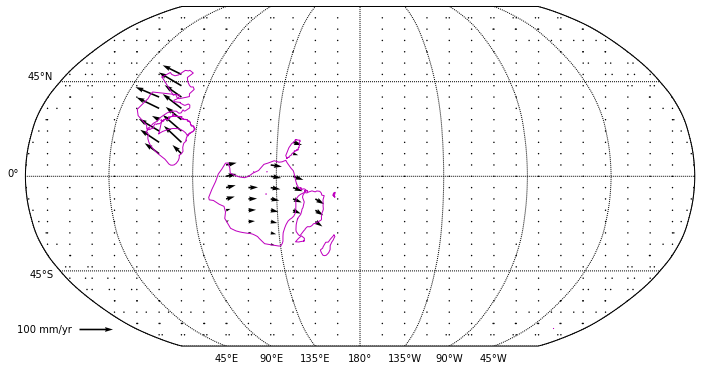

In [10]:

    topology_features = pygplates.FeatureCollection(input_topology_filename)
    rotation_model = pygplates.RotationModel(rotation_filename)

    # Create the basemap
    fig = plt.figure(figsize=(12,8),dpi=300)
    m3 = Basemap(resolution='c',projection='robin',lon_0=180.)
    #pmap = Basemap(resolution='c',projection='ortho',lat_0=30.,lon_0=60.)
    clip_path = m3.drawmapboundary()
    #pmap.drawmapboundary(fill_color='lightblue')
    m3.drawmeridians(np.arange(0, 360, 45), labels=[0,0,0,1],fontsize=10)
    m3.drawparallels(np.arange(-90, 90, 45), labels=[1,0,0,0],fontsize=10)
    ax = plt.gca()

    # Resolve our topological plate polygons (and deforming networks) to the current 'time'.
    # We generate both the resolved topology boundaries and the boundary sections between them.
    resolved_topologies = []
    shared_boundary_sections = []
    pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, shared_boundary_sections)

    lons, lats = np.meshgrid(Xnodes,Ynodes)
    # compute native x,y coordinates of grid.
    x, y = m3(lons, lats)

    for latitudes, longitudes in zip(poly_lats,poly_longs):
        x_geom,y_geom = m3(longitudes, latitudes)
        m3.plot(x_geom, y_geom, c = 'm')

    # plot SLP contours.
    # plot wind vectors on projection grid.
    # first, shift grid so it goes from -180 to 180 (instead of 0 to 360
    # in longitude).  Otherwise, interpolation is messed up.
    #ugrid,newlons = shiftgrid(180.,np.asarray(pt_vel_e),np.asarray(pt_lon),start=False)
    #vgrid,newlons = shiftgrid(180.,np.asarray(pt_vel_n),np.asarray(pt_lon),start=False)
    # transform vectors to projection grid.
    uproj,vproj,xx,yy = m3.transform_vector(u,v,Xnodes,Ynodes,31,31,returnxy=True,masked=True)

    # now plot.
    Q = m3.quiver(xx,yy,uproj,vproj,scale=2000,clip_path=clip_path)
    Q2 = m3.quiver(xx,yy,uproj,vproj,scale=2000,color='')

    # make quiver key.
    qk = plt.quiverkey(Q2, 0.08, 0.05, 100, '100 mm/yr', labelpos='W', color='k')

    plt.show()
